This notebook takes a a quick look at Covid-19 article dataset on Kaggle https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge  
It focuses on different ways of sifting through the articles.  
The noteboook is separated as such 

1. Loading and Cleaning
2. Keyword Search
3. Topic Modeling
4. Cosine Similarity

# Import Packages

In [1]:
!pip install --upgrade langdetect -q # install language detection

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import json # read json files

import glob #find pathnames
import random# for sampling
random.seed(4)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans# Import k-means to perform clusters analysis
from sklearn.metrics import silhouette_score #To chose the number of topics
from sklearn.metrics.pairwise import cosine_similarity

import nltk #natural language processing
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

                        
from gensim import corpora #Create Corprea
from gensim.models.ldamodel import LdaModel #LDA model

import pyLDAvis.gensim #Display Topics

        
stop_words =  set(stopwords.words('english'))
stop_words.update(['et', 'al',"addition", "respectively", "found", "although",'present',
                  'identified','Thu','Finally','either','suggesting','include',"well", 
                   "associated", "method", "result",'used','doi','display',
                  'https','copyright', 'holder','org','author','available','made','peer',
                  'reviewed','without','permission','license','rights','reserverd','Furthermore'
                  'using','preprint','allowed','following','may','thus','funder','International',
                 'granted','compared','will','one','two','use','different','likely','Discussion',
                 'medRexiv','Introduction','Moreover','known','funder','6','7','8','paywall' ,
                'downarrow','textstyle','1','2','3','4','5','9','10','0','include','number',
                'work','begin','fig','show','study','result','show','also','include','year',
                  'f','j','k','n','v','g','e','q','x','l'])


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading Files

In [2]:
#The files while they have some structure are not completely uniform so pandas.read_json() will not work in this case. For example one article could have one author and another five
#the Schema

#with open("/kaggle/input/CORD-19-research-challenge/json_schema.txt",'r') as f:
#    file = f.read()
#    print(file)


The following class Kaggle_Covid_19 contains the code for ETL of the data. there is also a method for the keyword search. (A class was creater beacuse the code was getting to repetative)

In [3]:
class Kaggle_Covid_19:
    '''Created to easy the ETL/EDA Kaggle Covid_19 dataset from:
    https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge'''
        
    def _article_paper_id_title(self,article):
        '''Create a list of a paper's ID and title''' 

        metadata = [article["paper_id"],article["metadata"]["title"]]
        return  metadata
    
    
    def _article_authors(self,article):
        '''Create a list of a paper's ID, authors and source'''
        authors = []

        for idx in range(len(article["metadata"]["authors"])):
            author = [article["paper_id"],article["metadata"]["authors"][idx]["first"], article["metadata"]["authors"][idx]["last"]]
            authors.append(author)
        return authors

    
    def _article_text(self,article):
        '''Create a list of a paper's ID, and abstracts and body text'''
        import numpy as np
        text = article["metadata"]["title"]
        abstract = ''
    
        try:
            for idx in range(len(article["abstract"])):
                abstract = abstract + '\n\n' + article["abstract"][idx]["text"]
            abstract = abstract.strip()
        except: abstract = ''
        
        for idx in range(len(article["body_text"])):
            text = text + '\n\n' + article["body_text"][idx]["section"] + '\n\n' + article["body_text"][idx]["text"]
        text = text.strip()
    
        article_text = [article["paper_id"],text,abstract]
        return article_text    
    
    
    
    def _check_lang(self,text,seed=0):
        '''Check the language of text'''
        
        from langdetect import detect, DetectorFactory
        DetectorFactory.seed = seed
        
        try:
            return detect(text)
    
        except: return None
    
    
    def _tokenize(self,text):
    
        '''Cleans Text Data by:
        1.Remove stopwords
        2.Remove punctuation
        3.Normalize text
        4.Lemmatize text'''
    
        from nltk.stem.wordnet import WordNetLemmatizer
        import re
        from nltk.tokenize import word_tokenize
    
        lemmatizer = WordNetLemmatizer()
        
        # normalize case and remove punctuation
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
        # tokenize text
        tokens = word_tokenize(text)
    
        # lemmatize(noun) and remove stop words
        lem = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        
        # lemmatize(verb) and remove stop words
        lem = [lemmatizer.lemmatize(word,pos = 'v') for word in lem ]
        
        # lemmatize(adjective) and remove stop words
        tokens  = [lemmatizer.lemmatize(word,pos = 'a') for word in lem ]

        return tokens


    def _load_files(self):
    
        '''(Kaggle) Takes in filepath and returns three dataframe with:
        1.["Paper_Id",'Text','Abstract']
        2.["Paper_Id","Title"]
        3.["Paper_Id","First_Name","Last_Name"]'''
    

    
        filepaths = glob.glob(self.filepath,recursive = True) #getting file paths
    
        articles = random.sample(filepaths,self.num_of_articles) #taking a sample as the corpus is to large (for Kaggle)
    
    
        #initialize lists
        titles_list = []
        authors_list = []
        text = []
    
        #Filling lists
        for article in articles:
            article = json.load(open(article, 'rb'))
            titles_list.append(self._article_paper_id_title(article))
            authors_list.extend([*self._article_authors(article)])              
            text.append(self._article_text(article)) 
    
        #Transform lists into DataFrames
            
        self.authors = pd.DataFrame(authors_list,columns = ["Paper_Id","First_Name","Last_Name"])
        self.titles  = pd.DataFrame(titles_list,columns = ["Paper_Id","Title"])
        self.texts   = pd.DataFrame(text,columns = ["Paper_Id",'Text','Abstract'])
        
        self._to_clean = pd.concat([self.texts["Paper_Id"],self.texts['Text'] + self.texts['Abstract']],axis = 1 )
        self._to_clean.columns =["Paper_Id",'Full_Text']





    def _clean_text(self):
        
        '''Produces a list of cleaned text data (load_files should be run first)'''
        import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
        #Combine all text data into one column
  
        lang = []
        
        for text in self._to_clean['Full_Text']:
            if self._check_lang(text) != None:
                lang.append(self._check_lang(text))
            else:lang.append(None)
    
        self._to_clean['Language'] = pd.Series(lang)
        
        #Remove articles that are not in english
        self._to_clean = self._to_clean[self._to_clean['Language'] == 'en']

        #Remove the Language column 
        self._to_clean = self._to_clean.drop('Language',axis = 1)
        #clean text data
        _clean_text = self._to_clean['Full_Text'].apply(self._tokenize) 
        self.clean_text = pd.concat([self._to_clean['Paper_Id'],_clean_text],axis = 1)

        #Remove unneeded dataframes 
        del self._to_clean
        del _clean_text

    
    def _tfidf(self):
        '''Creates TFIDF matrix'''
        # initialize tf-idf vectorizer 
        vectorizer = TfidfVectorizer()
        # compute tf-idf values
        self.tfidf_matrix = vectorizer.fit_transform([' '.join(doc) for doc in self.clean_text['Full_Text']])
        
        
    def _cosine_sim(self):
        '''Creates a dataframe of the cosine similarities of all articles'''
        self._tfidf()
        sims = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)#get similarity scores
        self.similarity_ = pd.DataFrame(list(sims)) # Create similarity dataframe

        #Change columns and index of the dataframe
        self.similarity_.columns = self.clean_text['Paper_Id']
        self.similarity_.index = self.clean_text['Paper_Id']


        
    def __init__(self, filepath,num_of_articles=1000):
        self.filepath = filepath
        self.num_of_articles = num_of_articles
        self._load_files()
        self._clean_text()
        self._cosine_sim()
        
        

    
    def keyword_Search(self,keywords,joint = True):
        '''Searches data set for articles (self.clean_text) containing keywords.
           
            joint: If True, return Paper Id's of articles containing all search terms.
                    If False, return Paper Id's of articles containing any of the search terms
        
            keywords: A list of words to search for in the articles
        
        
        '''
    
   
        keywords = self._tokenize(' '.join(keywords))
    
        papers = []
        if joint:
            for idx,row in covid.clean_text.iterrows():
    
                if all([word in row['Full_Text'] for word in ['cough','fever','chill']]):
                    papers.append(row['Paper_Id'])

            papers = pd.DataFrame({'Paper_Id':papers})        
            
        else:
            for idx,row in self.clean_text.iterrows():
                for word in keywords:
                    try:
                        if word in row['Full_Text']:
                             papers.append([row['Paper_Id'],word])
                    except: TypeError
            papers = pd.DataFrame(papers,columns = ['Paper_id','Keyword'])
            
        return papers
    
    
    def similarity(self,paper_id_,score = 0):
        '''Acepsts 
            paper_id: ID of the Article
            sim: similarity dataframe
            score: minimum similarity score [0,1]
        
            Returns a pd.Series with of similarity scores with a minimum value score
        '''
        similar_articles = self.similarity_.loc[self.similarity_[paper_id_]>score,paper_id_]
        return similar_articles.drop(paper_id_,axis = 0)


In [4]:
#Define file path
file_path = "/kaggle/input/" + "**/*.json" 

#Instantiate Class
covid = Kaggle_Covid_19(file_path,num_of_articles=10000)

The number of topics chosen for the LDA is usually done through trail and error. I prefer to use KMeans as a starting point 

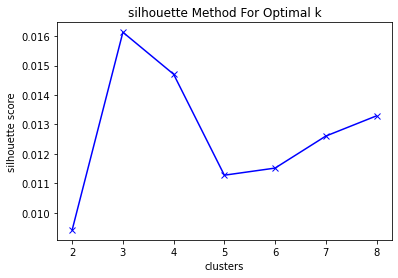

In [5]:
#init number of clusters
clus_num = 9

sil_score = []
Sum_of_squared_distances = []
 
for k in range(2,clus_num):
    kmeans = KMeans(n_clusters = k).fit(covid.tfidf_matrix)
    labels = kmeans.labels_
    sil_score.append(silhouette_score(covid.tfidf_matrix, labels, metric = 'euclidean'))
    
plt.plot(range(2,clus_num), sil_score, 'bx-')
plt.xlabel('clusters')
plt.ylabel('silhouette score')
plt.title('silhouette Method For Optimal k')
plt.show()

#the highest point denotes the number of topics to be used

# Topic modeling

In [6]:
_np = np.asarray(sil_score)  #convert to np.array

topic_num = _np.argmax() + 2 #set number of topics

#Create Corpus and Dictionary 
dictionary = corpora.Dictionary(covid.clean_text['Full_Text'])
corpus = [dictionary.doc2bow(text) for text in covid.clean_text['Full_Text']]

#Create LDA model
ldamodel = LdaModel(corpus, num_topics=topic_num,id2word=dictionary, passes=30)

#Display Topics 
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus,dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## Determine the Dominante Topic of each article

In [7]:
def topic_keywords(ldamodel,topic_num):
    '''Extract topics from LDA model'''
    keywords = {}
    for i in range(topic_num):
        keywords[i] = ', '.join(x[0] for x in ldamodel.show_topic(i))
    
    return keywords

In [8]:
#Extract the main topic for each document in the corpus
main_topic_prop = [sorted(article, key=lambda x: (x[1]), reverse=True)\
                   for i, article in enumerate(ldamodel[corpus])]

#Dictionary of topics in LDA model
topics = topic_keywords(ldamodel,topic_num)

#Create a Data Frame with the Main Topic and %score 
topic_Dataframe = pd.DataFrame([(doc[0][0],doc[0][1],topics[doc[0][0]]) for doc in main_topic_prop],\
                             columns = ['Dominant_Topic', '% Score', 'Topic_Keywords'])

topic_Dataframe  = pd.concat([covid.clean_text['Paper_Id'].reset_index(drop = True),topic_Dataframe],axis = 1)#Concate Paper ID for articles
topic_Dataframe 

,Paper_Id,Dominant_Topic,% Score,Topic_Keywords
0,PMC7125746,2,0.996782,"cell, virus, protein, viral, infection, sequen..."
1,3d8c32ca85f775492b317e5afc664200019e0cc4,1,0.997836,"19, covid, health, data, case, model, patient,..."
2,PMC7223945,0,0.771823,"patient, usepackage, infection, disease, treat..."
3,a313e9b1656e494d3cfcbd218b181a8dba346252,1,0.979919,"19, covid, health, data, case, model, patient,..."
4,6f93af7555f41f174f4871c7147c8f4b90174275,0,0.746466,"patient, usepackage, infection, disease, treat..."
...,...,...,...,...
9759,bf69fd53137145200ca5393dbf2c3c57c60f1255,2,0.999539,"cell, virus, protein, viral, infection, sequen..."
9760,PMC7195287,1,0.907442,"19, covid, health, data, case, model, patient,..."
9761,PMC7315149,1,0.848073,"19, covid, health, data, case, model, patient,..."
9762,4d6ccc56298377e00d531e182b49d255db913c2b,0,0.646743,"patient, usepackage, infection, disease, treat..."


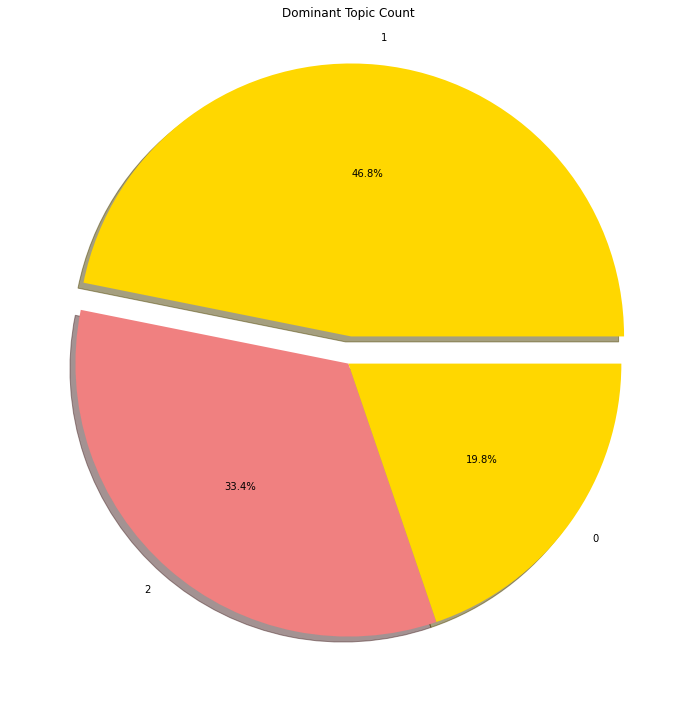

In [9]:
#create for plot.pie explode arg
explode = np.zeros(topic_num)
explode[0] = 0.1

#Display Dominant Topic count of articles as a proportion

topic_Dataframe['Dominant_Topic'].value_counts().plot.pie(colors=['gold',  'lightcoral'],\
                                                autopct='%1.1f%%', shadow=True,explode=explode,\
                                                figsize = (10,10),title='Dominant Topic Count')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Keyword search

In [20]:
symptoms = ['Fever', 'chills','Cough', 'difficulty breathing','Fatigue','body aches','Headache',
             'loss of taste or smell' ,'Sore throat','Congestion', 'runny nose','Nausea', 'vomiting','Diarrhea']

How many articles have information on **most** of the symptoms of Covid-19

In [21]:
keysearch = covid.keyword_Search(keywords =symptoms ,joint = True)
print('The number of articles that contain all the symptoms,' are: ',len(keysearch))

The number of articles that containall the keywords  ['Fever', 'chills', 'Cough', 'difficulty breathing', 'Fatigue', 'body aches', 'Headache', 'loss of taste or smell', 'Sore throat', 'Congestion', 'runny nose', 'Nausea', 'vomiting', 'Diarrhea']  are:  168


How many articles have information on **any** of the symptoms of Covid-19

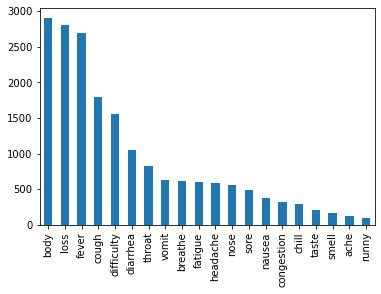

In [22]:
keysearch = covid.keyword_Search(keywords = symptoms,joint = False)
keysearch['Keyword'].value_counts().plot.bar()
plt.show()

# Cosine Similarity

Choosing a article found containing the keywords from *symptoms*. What are the other articles with a similarity score greater than 0.5.

In [27]:
covid.similarity(paper_id_ = keysearch.loc[0,'Paper_id'],score = 0.5)

Paper_Id
7649a2fc203b3f32bb54f9226adcd108152094d5    0.533705
7c1b1d84d22611ce472b1f7593d594a2f90355ce    0.529907
6fba236804cbfe944da479bb6e82abb0c53b47a0    0.978254
Name: PMC7125746, dtype: float64